In [1]:
from pathlib import Path
import datetime

import gymnasium as gym
import torch

from deep_q import DeepQFunc, DeepQFuncTrainer, DeepQFuncTester, ReplayBuffer, Discrete1ContinuousAction, TrainTracerInterface
from env import Env
from utils import clear_target_path, show_gif_on_jupyternb, to_gif


# Lab1 Deep处理连续的State空间
#### 使用CarPole-V1 环境，测试简单的Deep Q 如何处理连续的State空间和离散的Action空间

In [ ]:
GYM_ENV_NAME = 'CartPole-v1'
_train_gym_env = gym.make(GYM_ENV_NAME)
env = Env(_train_gym_env)

# 打印查看环境的动作空间和状态空间 
action_nums, state_space = _train_gym_env.action_space.n, _train_gym_env.observation_space
print(f'action num: {action_nums}, space: {state_space}')

TRAIN_EPOCH = 600
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
GAMMA = 0.99

# 使用指数递减的epsilon-greedy策略
START_EPSILON = 0.5
END_EPSILON = 0.05
DECAY_RATE = 0.99
EPSILON_LIST = [max(START_EPSILON * (DECAY_RATE ** i), END_EPSILON) for i in range(TRAIN_EPOCH)]

LOG_PATH = Path('./run/logs/cartpoleV1/run_normal')
MODEL_PATH = Path('./run/model/cartpoleV1/model.pth')
TEST_OUTPUT_PATH = Path('./run/test_result/cartpoleV1')

# _USE_CUDA = True and torch.cuda.is_available()
_USE_CUDA = False and torch.cuda.is_available()

q_func = DeepQFunc(state_space.shape[0], 
                   action_nums, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


replay_buffer = ReplayBuffer(10000)
q_func_trainer = DeepQFuncTrainer(q_func=q_func,
                                  env=env,
                                  replay_buffer=replay_buffer,
                                  learning_rate=LEARNING_RATE,
                                  batch_size=64,
                                  gamma=GAMMA,
                                  epsilon_list=EPSILON_LIST,
                                  logger_folder=LOG_PATH)


#### 训练模型

In [ ]:
clear_target_path(LOG_PATH)
clear_target_path(MODEL_PATH)
print(f'start training, now datetime: {datetime.datetime.now()}')
q_func_trainer.train(train_epoch=TRAIN_EPOCH, 
                     max_steps=1000, 
                     minimal_replay_size_to_train=64 * 10,
                     target_q_update_freq=10)
print(f'end training, saving model to: {MODEL_PATH}, now datetime: {datetime.datetime.now()}')

q_func.save(MODEL_PATH)

#### 开始测试

In [ ]:
q_test_func = DeepQFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))
q_func_tester = DeepQFuncTester(
    q_func=q_func.to('cpu'),
    env=_render_env
)
RESULT_GIF = TEST_OUTPUT_PATH / 'result.gif'
clear_target_path(RESULT_GIF)
q_func_tester.test(1000)
to_gif(_render_env._gym_env, RESULT_GIF, 1/30)

show_gif_on_jupyternb(RESULT_GIF)

# Lab2 Q-Learning改进算法： Double Q
### 使用Pendulum-v1 测试Double Q Learning对Q值系统高估的处理能力

In [ ]:
# 创建一个Tracer 来跟踪Q 网络训练过程中的Q值变化
# 我们只关注Q 函数对当前状态的最大值

from deep_q import AbstractQFunc, StateVector
from tensorboardX import SummaryWriter
import numpy as np


class QValueTracer(TrainTracerInterface):
    def __init__(self):
        self._cnt = 0

    def before_update_q_func(self, epoch: int, step: int, q_func: AbstractQFunc, current_state: StateVector, writer: SummaryWriter):
        writer.add_scalar('max_q_value', 
                          q_func.get_action_values(torch.tensor(np.array([current_state]))).max(dim=1).values.item(), 
                          self._cnt)       
        self._cnt += 1
        


In [ ]:
GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1'
_train_gym_env = gym.make(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/run_normal')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/model.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}')

# 打印查看环境的动作空间和状态空间 
action_space, state_space = _train_gym_env.action_space, _train_gym_env.observation_space
print(f'action: {action_space}, space: {state_space}')

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 11

TRAIN_EPOCH = 600
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
GAMMA = 0.99

# 使用指数递减的epsilon-greedy策略
START_EPSILON = 0.5
END_EPSILON = 0.05
DECAY_RATE = 0.99
EPSILON_LIST = [max(START_EPSILON * (DECAY_RATE ** i), END_EPSILON) for i in range(TRAIN_EPOCH)]


# _USE_CUDA = True and torch.cuda.is_available()
_USE_CUDA = False and torch.cuda.is_available()


q_func = DeepQFunc(state_space.shape[0], 
                   BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)

env = Env(_train_gym_env)

replay_buffer = ReplayBuffer(10000)
q_func_trainer = DeepQFuncTrainer(q_func=q_func, 
                                  env=env,
                                  replay_buffer=replay_buffer,
                                  learning_rate=LEARNING_RATE,
                                  batch_size=64,
                                  gamma=GAMMA,
                                  epsilon_list=EPSILON_LIST,
                                  logger_folder=LOG_PATH,
                                  action_converter=Discrete1ContinuousAction(action_space.low, action_space.high, BINS),
                                  train_tracer=QValueTracer()) 

#### 训练模型（没有使用double 策略，作为base line）

In [ ]:
clear_target_path(LOG_PATH)
clear_target_path(MODEL_PATH)
print(f'start training, now datetime: {datetime.datetime.now()}')
q_func_trainer.train(train_epoch=TRAIN_EPOCH, 
                     max_steps=1000, 
                     minimal_replay_size_to_train=64 * 10,
                     target_q_update_freq=10)
print(f'end training, saving model to: {MODEL_PATH}, now datetime: {datetime.datetime.now()}')

q_func.save(MODEL_PATH)

#### 开始测试

In [ ]:
q_test_func = DeepQFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))
q_func_tester = DeepQFuncTester(
    q_func=q_func.to('cpu'),
    env=_render_env,
    action_converter=Discrete1ContinuousAction(action_space.low, action_space.high, BINS)
)
RESULT_GIF = TEST_OUTPUT_PATH / 'result.gif'
clear_target_path(RESULT_GIF)
q_func_tester.test(1000)
to_gif(_render_env._gym_env, RESULT_GIF, 1/30)

show_gif_on_jupyternb(RESULT_GIF)


### 使用Pendulum-v1 测试Double Q Learning 能有效处理高估Q值

In [2]:
from deep_q import DoubleQFuncTrainer

GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1_WithDoubleQ'
_train_gym_env = gym.make(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/run_normal')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/model.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}')

# 打印查看环境的动作空间和状态空间 
action_space, state_space = _train_gym_env.action_space, _train_gym_env.observation_space
print(f'action: {action_space}, space: {state_space}')

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 11

TRAIN_EPOCH = 600
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
GAMMA = 0.99

# 使用指数递减的epsilon-greedy策略
START_EPSILON = 0.5
END_EPSILON = 0.05
DECAY_RATE = 0.99
EPSILON_LIST = [max(START_EPSILON * (DECAY_RATE ** i), END_EPSILON) for i in range(TRAIN_EPOCH)]


# _USE_CUDA = True and torch.cuda.is_available()
_USE_CUDA = False and torch.cuda.is_available()


q_func = DeepQFunc(state_space.shape[0], 
                   BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)

env = Env(_train_gym_env)

replay_buffer = ReplayBuffer(10000)
q_func_trainer = DoubleQFuncTrainer(q_func=q_func, 
                                  env=env,
                                  replay_buffer=replay_buffer,
                                  learning_rate=LEARNING_RATE,
                                  batch_size=64,
                                  gamma=GAMMA,
                                  epsilon_list=EPSILON_LIST,
                                  logger_folder=LOG_PATH,
                                  action_converter=Discrete1ContinuousAction(action_space.low, action_space.high, BINS),
                                  train_tracer=QValueTracer()) 

action: Box(-2.0, 2.0, (1,), float32), space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


NameError: name 'QValueTracer' is not defined

#### 训练模型（使用double Q策略）

In [ ]:
clear_target_path(LOG_PATH)
clear_target_path(MODEL_PATH)
print(f'start training, now datetime: {datetime.datetime.now()}')
q_func_trainer.train(train_epoch=TRAIN_EPOCH, 
                     max_steps=1000, 
                     minimal_replay_size_to_train=64 * 10,
                     target_q_update_freq=10)
print(f'end training, saving model to: {MODEL_PATH}, now datetime: {datetime.datetime.now()}')

q_func.save(MODEL_PATH)

#### 开始测试

In [ ]:
q_test_func = DeepQFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))
q_func_tester = DeepQFuncTester(
    q_func=q_func.to('cpu'),
    env=_render_env,
    action_converter=Discrete1ContinuousAction(action_space.low, action_space.high, BINS)
)
RESULT_GIF = TEST_OUTPUT_PATH / 'result.gif'
clear_target_path(RESULT_GIF)
q_func_tester.test(1000)
to_gif(_render_env._gym_env, RESULT_GIF, 1/30)

show_gif_on_jupyternb(RESULT_GIF)


### 结论
可以看到，Double Q 的Q值估计缺失稍微好一点

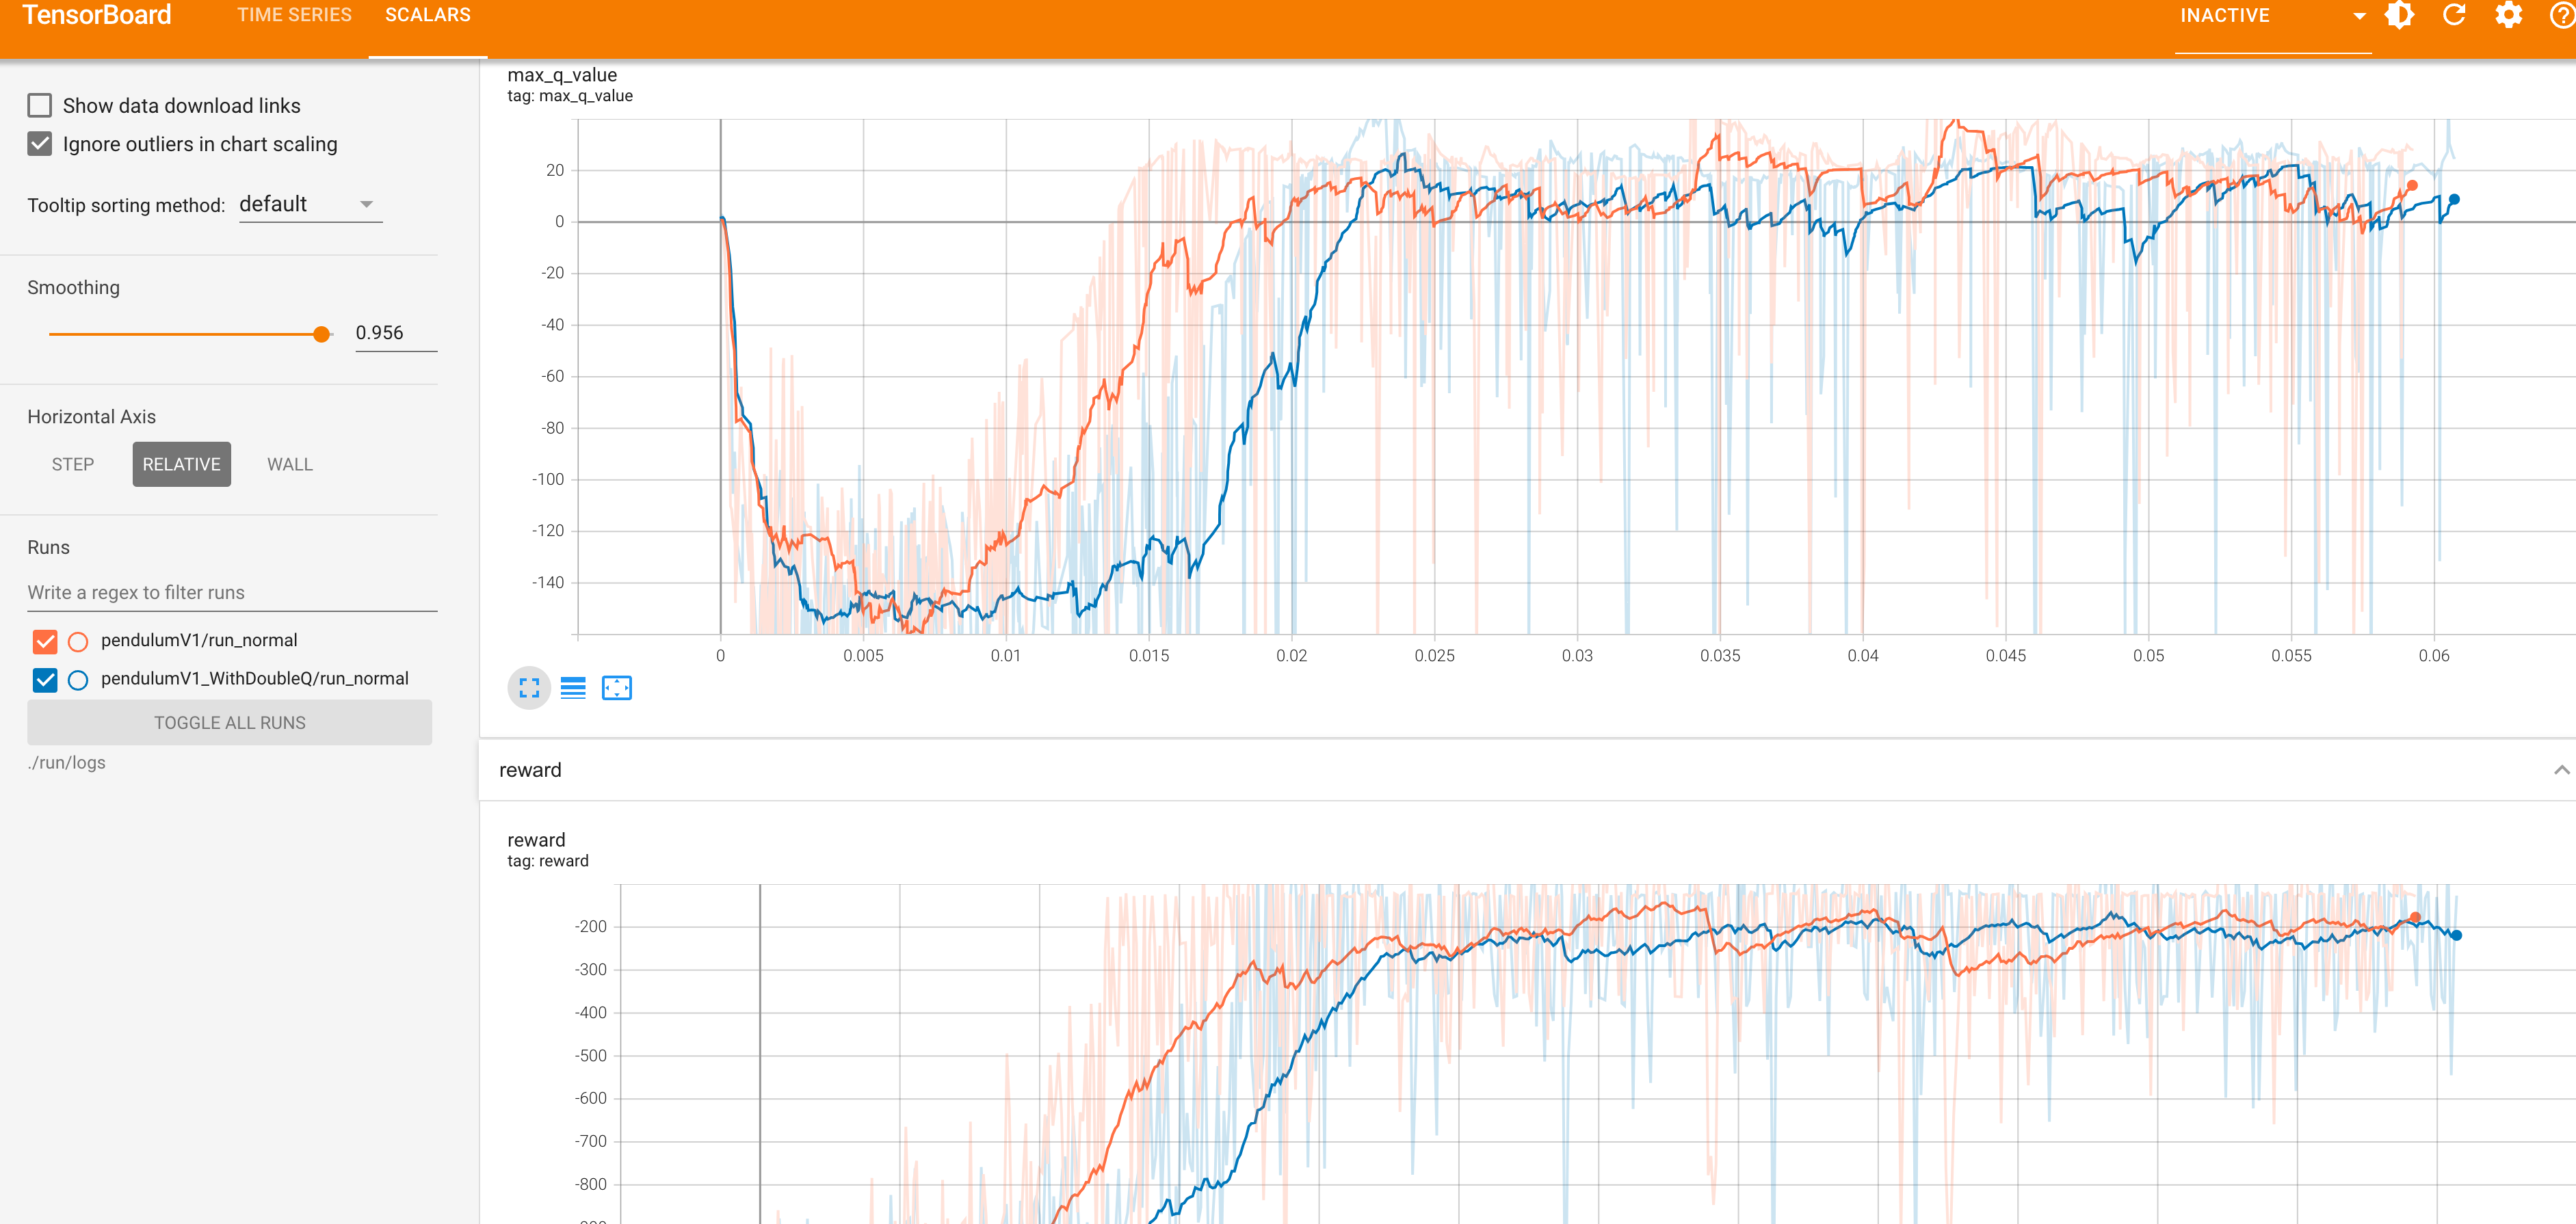

### 使用Pendulum-v1 测试Dueling  Q Learning

In [ ]:
from deep_q import DuelingQFunc

GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1_WithDuelingQ'
_train_gym_env = gym.make(GYM_ENV_NAME)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/run_normal')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/model.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}')

# 打印查看环境的动作空间和状态空间 
action_space, state_space = _train_gym_env.action_space, _train_gym_env.observation_space
print(f'action: {action_space}, space: {state_space}')

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 11

TRAIN_EPOCH = 600
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
GAMMA = 0.99

# 使用指数递减的epsilon-greedy策略
START_EPSILON = 0.5
END_EPSILON = 0.05
DECAY_RATE = 0.99
EPSILON_LIST = [max(START_EPSILON * (DECAY_RATE ** i), END_EPSILON) for i in range(TRAIN_EPOCH)]


# _USE_CUDA = True and torch.cuda.is_available()
_USE_CUDA = False and torch.cuda.is_available()


q_func = DuelingQFunc(state_space.shape[0], 
                   BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)

env = Env(_train_gym_env)

replay_buffer = ReplayBuffer(10000)
q_func_trainer = DoubleQFuncTrainer(q_func=q_func, 
                                  env=env,
                                  replay_buffer=replay_buffer,
                                  learning_rate=LEARNING_RATE,
                                  batch_size=64,
                                  gamma=GAMMA,
                                  epsilon_list=EPSILON_LIST,
                                  logger_folder=LOG_PATH,
                                  action_converter=Discrete1ContinuousAction(action_space.low, action_space.high, BINS),
                                  train_tracer=QValueTracer()) 

#### 训练开始（使用Dueling Q 网络）

In [ ]:
clear_target_path(LOG_PATH)
clear_target_path(MODEL_PATH)
print(f'start training, now datetime: {datetime.datetime.now()}')
q_func_trainer.train(train_epoch=TRAIN_EPOCH, 
                     max_steps=1000, 
                     minimal_replay_size_to_train=64 * 10,
                     target_q_update_freq=10)
print(f'end training, saving model to: {MODEL_PATH}, now datetime: {datetime.datetime.now()}')

q_func.save(MODEL_PATH)

#### 开始测试(使用Duel Q函数)

In [ ]:
q_test_func = DuelingQFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))
q_func_tester = DeepQFuncTester(
    q_func=q_func.to('cpu'),
    env=_render_env,
    action_converter=Discrete1ContinuousAction(action_space.low, action_space.high, BINS)
)
RESULT_GIF = TEST_OUTPUT_PATH / 'result.gif'
clear_target_path(RESULT_GIF)
q_func_tester.test(1000)
to_gif(_render_env._gym_env, RESULT_GIF, 1/30)

show_gif_on_jupyternb(RESULT_GIF)